In [1]:
import io
import ipywidgets as widgets
import matplotlib.pyplot as plt
import PIL.Image
import numpy as np
import urllib
from skimage.transform import resize
from matplotlib.image import imread
import os
from IPython.display import display
from skimage import io as io_url
import cv2
import numpy as np
from PIL import Image
from scipy.fft import fft2, ifft2, fftshift, ifftshift

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Create image widgets
image3_spatial = widgets.Image(format='png', width=500, height=500, description='Spatial')
image3_freq    = widgets.Image(format='png', width=500, height=500, description='Frequency')
sidebyside     = widgets.HBox([image3_spatial, image3_freq])

# Create slider/select widgets
slider_inner   = widgets.FloatSlider(value=0,      min=0, max=1,      step=0.01, description='Inner radius')
slider_outer   = widgets.FloatSlider(value=1.44/2, min=0, max=1.44/2, step=0.01, description='Outer radius')

buf            = io.BytesIO()

orig_img = io_url.imread('https://img2.zergnet.com/2309662_300.jpg')
orig_img = np.mean(orig_img, -1)

x = np.fft.fftfreq(orig_img.shape[0])
y = np.fft.fftfreq(orig_img.shape[1])

xv, yv = np.meshgrid(x, y)
xv = np.fft.fftshift(xv)
yv = np.fft.fftshift(yv)

def filter_frequency(orig_img, mask):
    """
    Remove frequency based on the given mask.
    Params:
      orig_img: numpy image
      mask: same shape with orig_img indicating which frequency hold or remove
    Output:
      f_img: frequency image after applying mask
      img: image after applying mask
    """
    # Fourier transform of the original image
    f_img = fft2(orig_img)

    # Shift frequency coefficients to center
    f_img_shifted = fftshift(f_img)

    # Apply mask in frequency domain
    f_img_filtered = f_img_shifted * mask

    # Shift frequency coefficients back
    f_img_filtered_shifted = ifftshift(f_img_filtered)

    # Inverse transform
    img = np.abs(ifft2(f_img_filtered_shifted))

    return f_img_filtered, img

def on_value_change3(change):
    mask = (np.sqrt(xv**2 + yv**2) < slider_outer.value) & \
           (np.sqrt(xv**2 + yv**2) >= slider_inner.value)
    mask = np.float32(mask)

    fimg, img = filter_frequency(orig_img, mask)

    # Convert frequency domain image to a format that PIL can handle
    fimg = np.abs(fimg)  # Take magnitude of the complex values
    img = np.log(0.0001 * img + 1)  # Log transformation

    # Normalize images
    img = (255 * img / img.max()).astype(np.uint8)
    fimg = (255 * fimg / fimg.max()).astype(np.uint8)

    # Save images to buffer
    buf.seek(0)
    PIL.Image.fromarray(img).save(buf, 'png')
    image3_spatial.value = buf.getvalue()

    buf.seek(0)
    PIL.Image.fromarray(fimg).save(buf, 'png')
    image3_freq.value = buf.getvalue()

slider_inner.observe(on_value_change3, names='value')
slider_outer.observe(on_value_change3, names='value')

on_value_change3(0)

display(sidebyside)
display(slider_inner)
display(slider_outer)

FloatSlider(value=0.0, description='Inner radius', max=1.0, step=0.01)

FloatSlider(value=0.72, description='Outer radius', max=0.72, step=0.01)

In [ ]:
def read_img(img_path, img_size=(512, 512)):
  """
    + Đọc ảnh
    + Chuyển thành grayscale
    + Thay đổi kích thước ảnh thành img_size
  """
  img = cv2.imread(img_path, 0)
  img = cv2.resize(img, img_size)
  return img


def create_hybrid_img(img1, img2, r):
    """
    Create hydrid image
    Params:
    img1: numpy image 1
    img2: numpy image 2
    r: radius that defines the filled circle of frequency of image 1. Refer to the homework title to know more.
    """
    # You need to implement the function

    # Step 1: Fourier transform for two input images
    img1_fft = fft2(img1)
    img2_fft = fft2(img2)

    # Step 2: Shift the frequency coefficients to center using fftshift
    img1_fft_shifted = fftshift(img1_fft)
    img2_fft_shifted = fftshift(img2_fft)

    # Step 3: Create mask based on radius (r)
    rows, cols = img1.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), dtype=np.float32)
    for i in range(rows):
        for j in range(cols):
            dist = np.sqrt((i - crow) ** 2 + (j - ccol) ** 2)
            if dist <= r:
                mask[i, j] = 1

    # Step 4: Combine frequencies of two images using mask
    img1_hybrid_fft = img1_fft_shifted * mask
    img2_hybrid_fft = img2_fft_shifted * (1 - mask)
    hybrid_img_fft = img1_hybrid_fft + img2_hybrid_fft

    # Step 5: Shift the frequency coefficients back using ifftshift
    hybrid_img_fft_shifted = ifftshift(hybrid_img_fft)

    # Step 6: Invert transform using ifft2
    hybrid_img = np.abs(ifft2(hybrid_img_fft_shifted))

    return hybrid_img



(-0.5, 511.5, 511.5, -0.5)

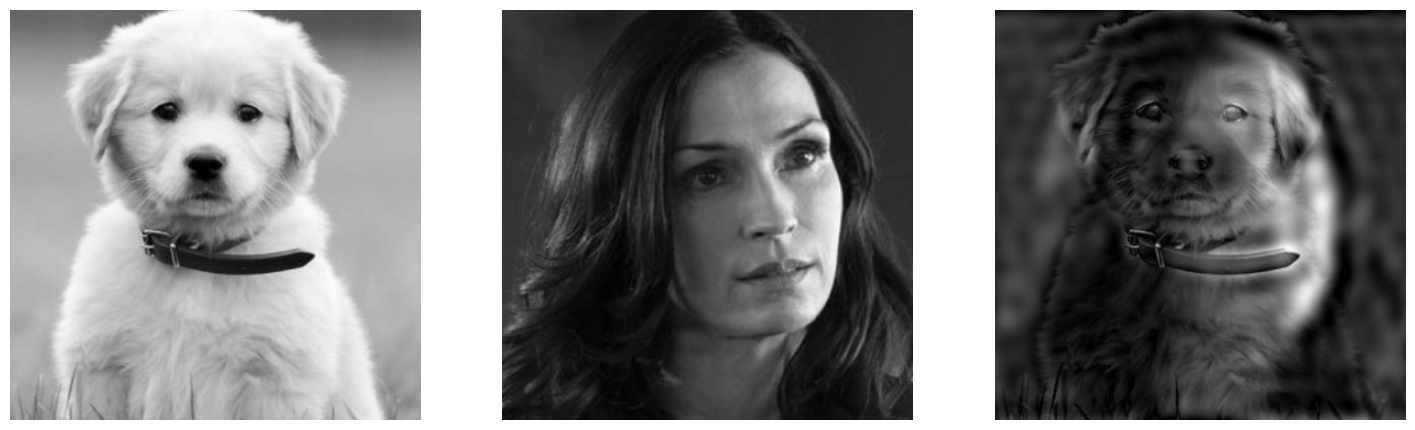

In [ ]:
image_1_path = "/content/drive/MyDrive/GoogleColabResources/ex2-34-images/2309662_300.jpg" # <-- need to change
image_2_path = "/content/drive/MyDrive/GoogleColabResources/ex2-34-images/2325631_300.jpg" # <-- need to change
img_1 = read_img(image_1_path)
img_2 = read_img(image_2_path)
hybrid_img = create_hybrid_img(img_2, img_1, 14)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 15))
axes[0].imshow(img_1, cmap="gray")
axes[0].axis("off")
axes[1].imshow(img_2, cmap="gray")
axes[1].axis("off")
axes[2].imshow(hybrid_img, cmap="gray")
axes[2].axis("off")